In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows = 99999

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (8, 8)  
plt.rcParams['lines.linewidth'] = .5

In [2]:
def detect(data,price,n_days,lookback,fraction_movement):

    np_data = data.T.values
    np_price = price.T.values
    np_open = np_price[0]
    
    pattern_ls=[]
    
    for i in (range(len(np_data[0]))):
        op=np_data[0][i-lookback:i]
        hi=np_data[1][i-lookback:i]
        lo=np_data[2][i-lookback:i]
        cl=np_data[3][i-lookback:i]

        try :
            for n in range(n_days,n_days+1): 
                if  np_open[i+n+1] - np_open[i+1] >= fraction_movement*np_open[i+1]:
                    
                    if i >lookback :
                        #print(np_open[i+n+1] - np_open[i+1],fraction_movement*np_open[i+1],i)
                        a=cl-op
                        body=(a - np.min(a))/np.ptp(a)
                        a=hi-lo
                        range_=(a - np.min(a))/np.ptp(a)
                        info = ["buy",int(n),int(lookback),float(fraction_movement),int(i)]
                        pattern_ls.append([body,range_,info])
                    #print('Down',i,n)
                    break
                elif np_open[i+1] - np_open[i+n+1] >= fraction_movement*np_open[i+1] :
                    
                    if i >lookback :                    
                        #print(np_open[i+1] - np_open[i+n+1],fraction_movement*np_open[i+1],i)
                        a=cl-op
                        body=(a - np.min(a))/np.ptp(a)
                        a=hi-lo
                        range_=(a - np.min(a))/np.ptp(a)
                        info = ["sell",int(n),int(lookback),float(fraction_movement),int(i)]
                        pattern_ls.append([body,range_,info])
                    #print('Up',i,n)
                    break
        except :
            pass

    pattern_detect = np.asarray(pattern_ls, dtype="object")
    
    ls_tmp = []
    for e in pattern_detect[:,2]:
        ls_tmp.append(e[0])
    
    print("Found", len(ls_tmp) ,"patterns")
    print("Buy" ,len([e for e in ls_tmp if "buy" == e]))
    print("Sell" , len(ls_tmp)-(len([e for e in ls_tmp if "buy" == e])))
            
    return pattern_detect

def report(tradelist,initial_capital,type_analisy,Benchmark):
        %matplotlib inline
        import quantstats as qs
        qs.extend_pandas()
    
        tradelist = tradelist.fillna(0)
        tradelist = tradelist[tradelist!=0]
        tradelist.iloc[0] = tradelist.iloc[0]+initial_capital
        tradelist = tradelist.cumsum()
        
        if type_analisy == 0:
            qs.plots.snapshot(tradelist)
            
        if type_analisy == 1:    
            if len(Benchmark)==0:
                qs.reports.basic(tradelist)
            else:
                qs.reports.basic(tradelist,Benchmark)
                
        if type_analisy == 2:    
            if len(Benchmark)==0:
                qs.reports.full(tradelist)
            else:
                qs.reports.full(tradelist,Benchmark)
                

def remove_outlier(y):
    
    high_percentile = 0.99
    low_percentile = 0.01

    lq = np.quantile(y,low_percentile)
    hq = np.quantile(y,high_percentile)
    print(lq,hq)
    y = y.clip(lq,hq)

    return y


from numba import jit
@jit(nopython=True)
def engine_MP(pct , pct_total , ptn_body , ptn_range , np_data, direzione ,lookback):
    
    conta=0
    mp=np.zeros_like(np_data[0])

    for i in (range(len(np_data[0]))):
        if i >lookback:
            op=np_data[0,i-lookback:i] 
            hi=np_data[1,i-lookback:i]
            lo=np_data[2,i-lookback:i]
            cl=np_data[3,i-lookback:i]
        
            a=cl-op
            body=(a - np.min(a))/np.ptp(a)  
            
            a=hi-lo
            range_=(a - np.min(a))/np.ptp(a)
        
            diff_1=body-ptn_body
            diff_2=range_-ptn_range
            diff_1=np.where((diff_1<pct)&(diff_1>-pct),1,diff_1)
            diff_1=np.where(diff_1!=1,0,diff_1)
            diff_2=np.where((diff_2<pct)&(diff_2>-pct),1,diff_2)
            diff_2=np.where(diff_2!=1,0,diff_2)
            
            if (my_sum(diff_1)>=pct_total)&(my_sum(diff_2)>=pct_total)&(direzione=="buy"):
                mp[i] = 1
            if (my_sum(diff_1)>=pct_total)&(my_sum(diff_2)>=pct_total)&(direzione=="sell"):
                mp[i] = 1
    return mp
    
@jit(nopython=True)
def my_sum(d):
    total = 0.0
    for valore in d:
        total += valore
    return total
    
def to_live(THRESHOLD_VALUE , THRESHOLD_PATTERN, data,  pattern_detect):
    
        np_data = data.T.values
        ptn_body =  pattern_detect[0]
        ptn_range = pattern_detect[1]
        direzione = pattern_detect[2][0]
        lookback = pattern_detect[2][2]
        #n_days = pattern_detect[2][1]
        
        pct=round(1-float((1/100)*THRESHOLD_VALUE),2)
        pct_total=int((lookback/100)*THRESHOLD_PATTERN)


        signal = engine_MP(pct,pct_total,ptn_body,ptn_range,np_data,direzione,lookback)

        return signal


@jit(nopython=True)
def propagate_ones(arr, steps):
    result = np.zeros_like(arr)  # Crea un array di zeri con la stessa forma di arr
    ones_indices = np.where(arr == 1)[0]  # Trova gli indici dei valori 1 in arr

    for idx in ones_indices:
        result[idx] = 1  # Imposta il valore 1 nella posizione corrente

        # Propaga il valore 1 in avanti per X passi
        for step in range(1, steps + 1):
            if idx + step < len(arr):
                result[idx + step] = 1
            else:
                break  # Esci se raggiungi la fine dell'array

    return result

@jit(nopython=True)
def TP_SL(tradelist,TP,SL):
    
    a=tradelist.copy()
    if (TP!=0)|(SL!=0):            

        if TP == 0 :
            TP = np.inf
        if SL == 0:
            SL = np.inf

        b = a.copy()
        cnt = 1
        for e in range(len(a)):
            if a[e]!=0:
                a[e]=cnt
            if (a[e]==0)&(a[e-1]!=0):
                cnt=cnt+1
        
        for cnt_value in range(1, int(max(a)) + 1):
            mask = np.where(a == cnt_value)[0]
            z = np.cumsum(b[mask])
            tp_idx =  np.where(z > TP)[0]
            sl_idx = np.where(z < -SL)[0]

            if len(tp_idx) > 0 or len(sl_idx) > 0:
                first = min(np.inf if len(tp_idx) == 0 else tp_idx[0]+1, np.inf if len(sl_idx) == 0 else sl_idx[0]+1)
                q = b[mask]
                q[first:] = 0
                b[mask] = q
    
        return b
    else:
        return a
        
def sharpe_ratio(operations):
    
    equity = np.cumsum(operations)
    netprofit = equity[-1]
    std = np.std(equity)
    if std != 0:
        return round(netprofit / std,2)
    else:
        return -99999

def drawdown_max(operations):

    equity_cumulata = np.cumsum(operations)
    maxvalue = np.maximum.accumulate(equity_cumulata)
    drawdown = equity_cumulata - maxvalue
    return min(drawdown)

function_set=('neg', 'inv' ,'add', 'mul', 'sqrt', 'log', 'cos', 'sin','sub', 'div', 'min', 'max', 'abs', 'tan')


def add_fail_event(df_y , pct , molt_dev_std , direzione):

    df = df_y.copy()
    
    windows = int(len(df)*pct)
    start_test = np.random.randint(1, len(df)-windows) 
    
    STD = df[start_test:start_test+windows].std()
    
    import random
    
    def genera_serie_tra_valori(X, valore_minimo, valore_massimo):
        serie = [random.uniform(valore_minimo, valore_massimo) for _ in range(X)]
        return serie
    
    X = 1000000  # Lunghezza della serie
    valore_minimo = -STD*molt_dev_std  # Valore minimo desiderato
    valore_massimo = STD*molt_dev_std  # Valore massimo desiderato
    
    
    if direzione == "long":
        while True:
            serie_generata = genera_serie_tra_valori(X, valore_minimo, valore_massimo)
            fail_trade_list = random.sample(serie_generata, windows)
            if sum(fail_trade_list)<0:
                break
    else:
        while True:
            serie_generata = genera_serie_tra_valori(X, valore_minimo, valore_massimo)
            fail_trade_list = random.sample(serie_generata, windows)
            if sum(fail_trade_list)<0:
                break
    df[start_test:start_test+windows]=fail_trade_list

    return df

def check_history_name(file_name,dir_history):
    import os
    storici = os.listdir(dir_history)
    for e in storici:
        x=e.split("_")[0]
        x=x.replace("@","")
        if x == file_name:
            file_name=e
            break
    return file_name

def resample_standard_session(original_tf,resample_tf,dataset):
    
    original_tf=int(original_tf.replace("Min",""))
    resample_tf=int(resample_tf.replace("Min",""))
    df_0=dataset.copy()
    
    df_0.index=df_0.index - pd.DateOffset(minutes=original_tf)
    df_resample=df_0.resample(str(resample_tf)+'Min').agg({'open' : 'first', 'high' : 'max', 'low' : 'min', 'close' : 'last','volume':'sum'})
    
    if resample_tf == 1440 :
        df_resample = df_resample
    else:
        df_resample.index=df_resample.index + pd.DateOffset(minutes=resample_tf)
        
    df_resample=df_resample.dropna()
    return df_resample

In [3]:
import os
import numpy as np
import pandas as pd

dir_home = (r"C:\Users\Drako\GPlearn")

os.chdir(dir_home)
valori=pd.read_csv("Markets_Specifications_Live_2023.csv",sep=",",encoding='cp1252')
valori.reset_index(inplace=True)
valori.Exchange_Time=np.where(valori.Exchange_Time==-6,"CST6CDT",valori.Exchange_Time)
valori.Exchange_Time=np.where(valori.Exchange_Time=="-5","EST5EDT",valori.Exchange_Time)
valori.Exchange_Time=np.where(valori.Exchange_Time=="1","CET",valori.Exchange_Time)
valori["Simbolo"]=valori.Physical
valori=valori[(valori.Physical!="KC")&(valori.Physical!="TY")]

valori

,index,SecurityName,Exchange Code,Physical,Underlying Future,MarketTypeName,Exchange,BigPointValue,Unit,Margins,Regular Open,Regular Close,Custom Open,Custom Close,Tick,Cost,AMP_simb,Exchange_Time,TT_Code,Simbolo
0,0,Australian Dollar,6A,AD,Australian Dollar,Currencies,CME,100000,0.00,2000,1700,1600,720,1400,0.000100,20.0,DA6,CST6CDT,6A,AD
1,1,Soybean Oil,ZL,BO,Soybean Oil,Agriculturals,CME,60,0.00,2750,1900,1320,830,1315,0.010000,20.0,ZLE,CST6CDT,ZL,BO
2,2,British Pound,6B,BP,British Pound,Currencies,CME,62500,0.00,2500,1700,1600,720,1400,0.000100,15.0,BP6,CST6CDT,6B,BP
3,3,Crude Oil,CL,CL,Crude Oil,Energies,CME,1000,0.10,6000,1800,1700,900,1430,0.010000,20.0,CLE,EST5EDT,CL,CL
4,4,Euro FX,6E,EC,Euro FX,Currencies,CME,125000,0.00,3000,1700,1600,720,1400,0.000100,20.0,EU6,CST6CDT,6E,EC
5,5,E-Mini S&P MidCap 400,EMD,EMD,E-Mini S&P MidCap 400,Stock Indices,CME,100,0.00,14000,1700,1600,830,1515,NaN,NaN,EMD,CST6CDT,EMD,EMD
6,6,E-mini S&P 500,ES,ES,E-mini S&P 500,Stock Indices,CME,50,0.10,12000,1700,1600,830,1515,0.250000,25.0,EP,CST6CDT,ES,ES
7,7,DAX Futures,FDAX,FDAX,DAX Futures,Stock Indices,EUREX,25,0.20,30000,110,2200,800,2200,0.500000,50.0,FDX,CET,FDAX,FDAX
8,8,EURO STOXX 50 Index,FESX,FESX,EURO STOXX 50 Index,Stock Indices,EUREX,5,0.00,3000,110,2200,800,2200,0.500000,10.0,DSX,CET,FESX,FESX
9,9,Euro Bund,FGBL,FGBL,Euro Bund,Fixed Income,EUREX,1000,0.00,2400,110,2200,800,2200,0.010000,15.0,DB,CET,FGBL,FGBL


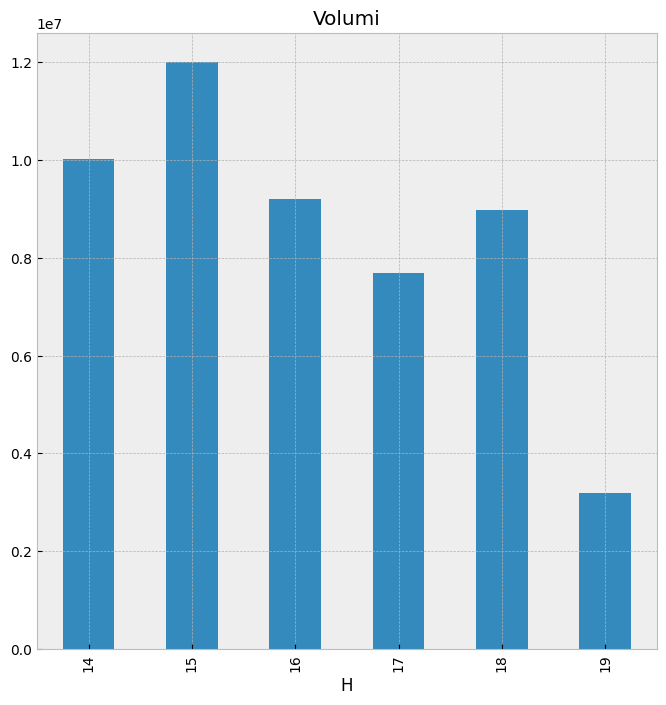

-570.0000000000017 600.0


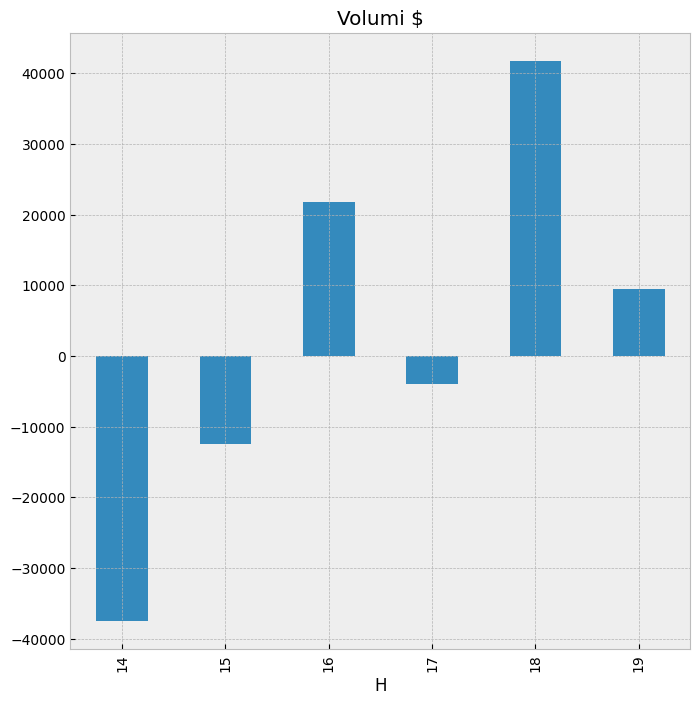

,open,high,low,close,volume,H,PNL
date_time,,,,,,,
2010-01-04 15:00:00,134.250,134.550,134.025,134.150,3704,15,-40.0
2010-01-04 16:00:00,134.150,134.275,133.575,133.750,2203,16,-170.0
2010-01-04 17:00:00,133.725,133.775,133.300,133.450,1559,17,-120.0
2010-01-04 18:00:00,133.425,133.600,133.250,133.475,1105,18,20.0
2010-01-04 19:00:00,133.475,133.475,133.150,133.250,1233,19,20.0


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()



dir_history = (r"C:\Users\Drako\TS_API\15102023")

SIMBOLO = "LC" 

BIGPOINTVALUE = int(valori.BigPointValue[valori.Physical==SIMBOLO])

os.chdir(dir_history)
file_name  =  check_history_name(SIMBOLO,dir_history)
dataset = pd.read_csv(file_name , index_col="date_time" , parse_dates=["date_time"] , engine="pyarrow")

utc_offset = "Etc/GMT0" #Etc/GMT-4 CST6CDT Etc/GMT-12

#dataset.index=dataset.index.tz_localize("UTC").tz_convert(utc_offset) 
#dataset.index=dataset.index.tz_localize(None)

REAL_MONEY = len(dataset)-int(len(dataset)*0.1)

RESAMPLE = "60Min"

dataset = resample_standard_session("60Min",RESAMPLE,dataset)

dataset = dataset.loc["2010-01-01":]

#scaler.fit(dataset.loc[:"2020-01-01"])
#df_scaled = scaler.transform(dataset)
#df_scaled = pd.DataFrame(df_scaled)
#df_scaled.index = dataset.index
#df_scaled.columns = dataset.columns


"""import legitindicators

data_filter=dataset.iloc[:].copy()
for e in data_filter.columns:
    data_filter[e]= legitindicators.super_smoother(data_filter[e], 10)"""

dataset["H"]=dataset.index.hour
dataset.groupby("H").sum().volume.plot.bar(title="Volumi")
plt.show()

dataset["PNL"] = (dataset["open"].shift(-1)-dataset["open"])*BIGPOINTVALUE
dataset["PNL"] = dataset["PNL"].fillna(0)
dataset["PNL"] = remove_outlier(dataset["PNL"])
dataset.groupby("H").sum().PNL.plot.bar(title="Volumi $")
plt.show()
dataset.head()


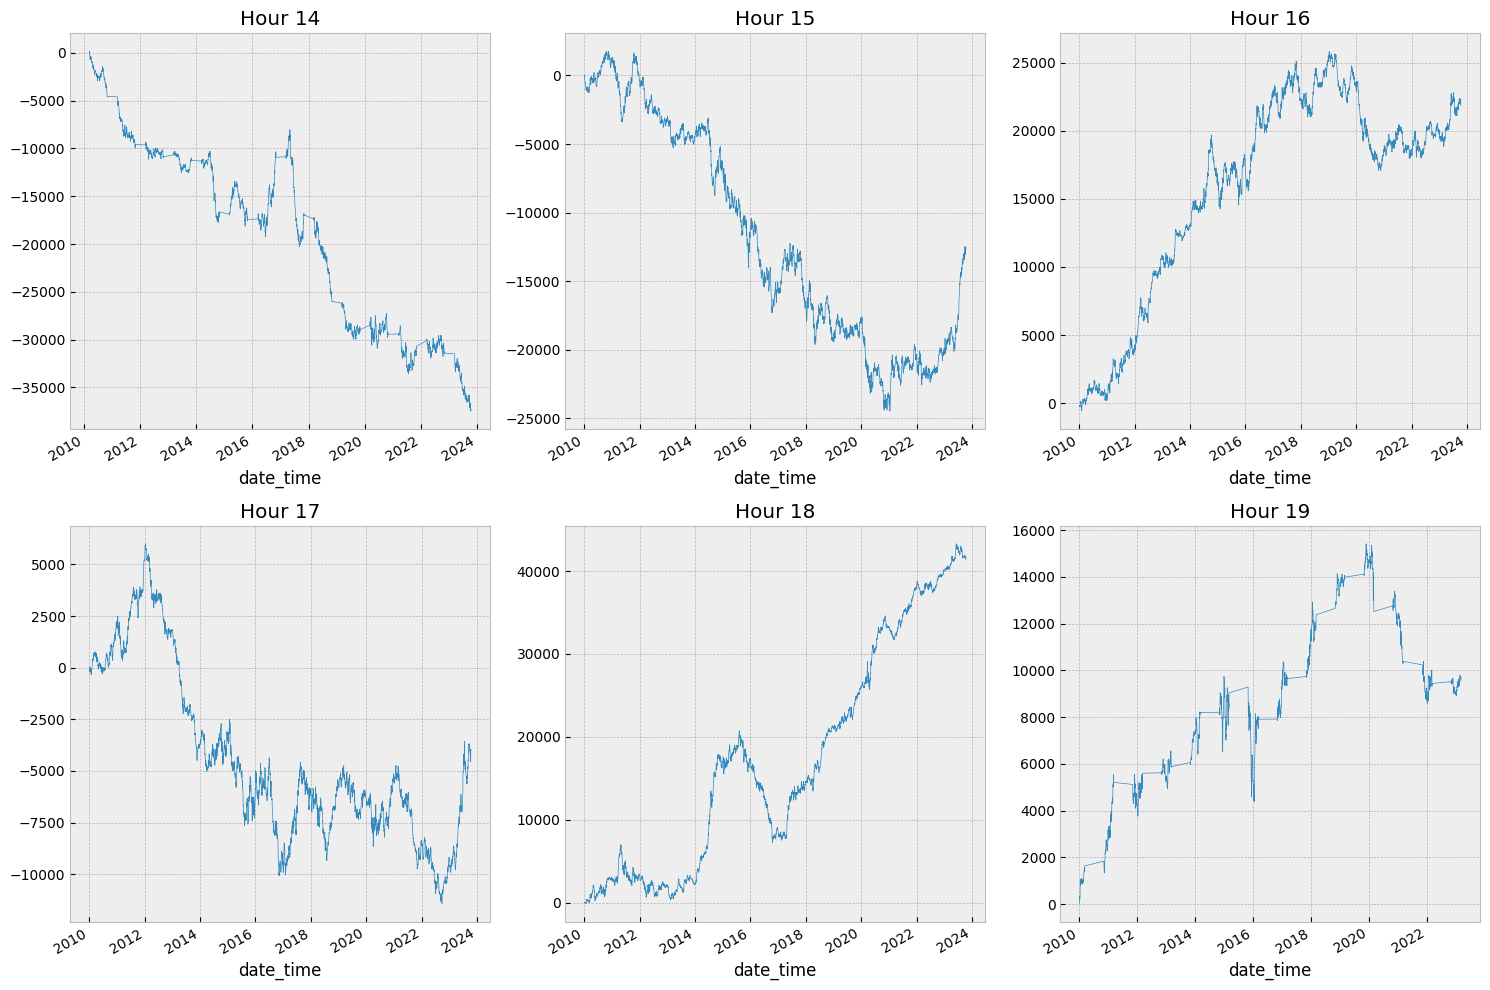

In [5]:
import numpy as np
import matplotlib.pyplot as plt

a = dataset["PNL"].copy()
ls_h = list(set(a.index.hour))
ls_h.sort()

# Specifica il numero di colonne per ogni riga
col_per_row = 3

# Calcola il numero totale di righe necessarie
num_rows = (len(ls_h) + col_per_row - 1) // col_per_row

# Crea una figura con sottofigure
fig, axes = plt.subplots(num_rows, col_per_row, figsize=(15, 5 * num_rows))

for i, e in enumerate(ls_h):
    row_idx = i // col_per_row
    col_idx = i % col_per_row

    # Seleziona l'asse appropriato
    if num_rows > 1:
        ax = axes[row_idx, col_idx]
    else:
        ax = axes[col_idx]

    # Traccia i dati e imposta il titolo
    a[a.index.hour == e].cumsum().plot(ax=ax, title="Hour " + str(e))

# Rimuovi eventuali sottofigure vuote
for i in range(len(ls_h), num_rows * col_per_row):
    if num_rows > 1:
        fig.delaxes(axes[i // col_per_row, i % col_per_row])
    else:
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [144]:
selected_hours = []

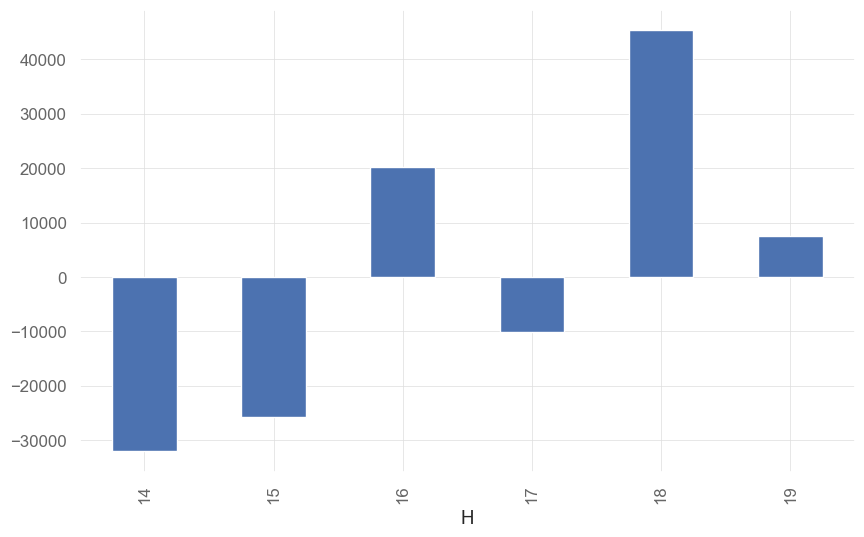

<Axes: xlabel='date_time'>

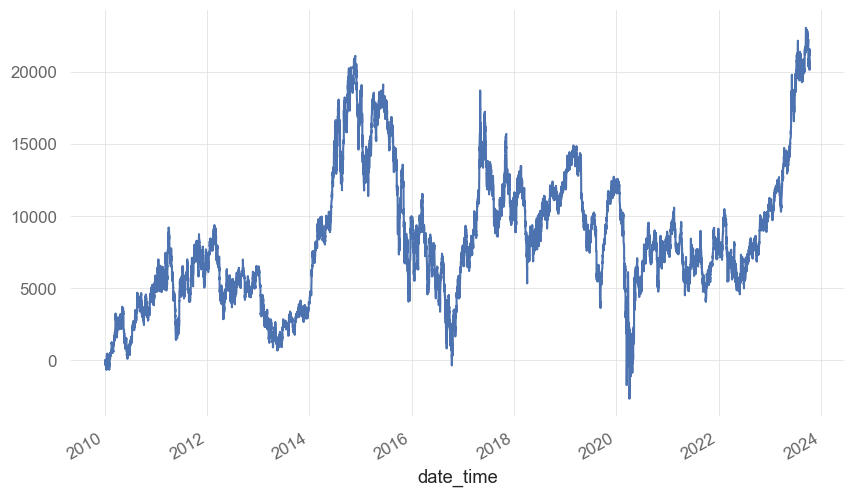

In [145]:
import random


dataset["PNL"] = dataset.open.copy()
dataset["PNL"] = (dataset["PNL"].shift(-1)-dataset["PNL"])*BIGPOINTVALUE


if len(selected_hours)!=0:
    dataset["PNL"][~dataset["PNL"].index.hour.isin(selected_hours)]=np.nan

dataset["PNL"] = dataset["PNL"].fillna(0)
#dataset["PNL"] = remove_outlier(dataset["PNL"])

dataset["random_signal"]= [random.randint(0, 1) for _ in range(len(dataset))]
y0=dataset["random_signal"].copy()
y0=y0.shift(-1,fill_value=0)
y0=y0.fillna(0)
y0=y0.astype(int)

check_h =  dataset["PNL"].iloc[:REAL_MONEY].copy().to_frame()
check_h["H"]=check_h.index.hour
check_h.groupby("H").sum().PNL.plot.bar()
plt.show()

dataset["PNL"].cumsum().plot()


In [131]:
LOOK_AHEAD = 3
LOOK_BACK = 30
FRACTION_MOVEMENT = 0.01

pattern_detect  = detect(dataset ,dataset+2 , LOOK_AHEAD , LOOK_BACK , FRACTION_MOVEMENT)


Found 1437 patterns
Buy 751
Sell 686


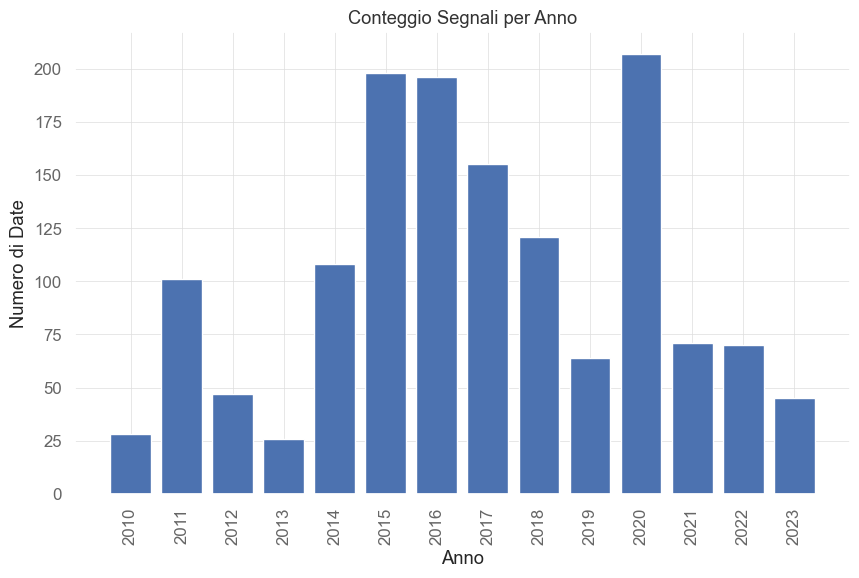

In [132]:
date_list = []
for e in pattern_detect:
    x=e[2][-1]
    date_list.append(str(dataset.index[x]))
    
from collections import Counter
conteggio_per_anno = Counter(date.split("-")[0] for date in date_list)

# Estrai gli anni e i conteggi come liste separate
anni = list(conteggio_per_anno.keys())
conteggi = list(conteggio_per_anno.values())

# Crea il grafico a barre
plt.bar(anni, conteggi)

# Aggiungi etichette
plt.xlabel("Anno")
plt.ylabel("Numero di Date")
plt.title("Conteggio Segnali per Anno")
plt.xticks(rotation=90)
# Mostra il grafico
plt.show()

In [133]:
print ("Numero si segnali minimo:",int(len(dataset)*0.1))
n_min_signal = int(len(dataset)*0.1)

Numero si segnali minimo: 1732


In [134]:
from tqdm.notebook import tqdm

THRESHOLD_VALUE = 71
THRESHOLD_PATTERN = 71

X0 = pd.DataFrame(index=dataset.index)

for I in tqdm(range(len(pattern_detect))):
    exit = pattern_detect[I][2][1]
    cnt =  pattern_detect[I][2][-1]
    signal = to_live(THRESHOLD_VALUE , THRESHOLD_PATTERN, dataset,  pattern_detect[I]) #73 #73
    if len(signal[signal!=0]) >n_min_signal:
        print("ptn_"+str(cnt),len(signal[signal!=0]),"inputs found")
        X0["ptn_"+str(cnt)] = signal


  0%|          | 0/1437 [00:00<?, ?it/s]

ptn_267 3026 inputs found
ptn_268 2892 inputs found
ptn_269 2825 inputs found
ptn_390 2471 inputs found
ptn_391 2316 inputs found
ptn_418 3666 inputs found
ptn_486 2750 inputs found
ptn_523 2409 inputs found
ptn_659 2043 inputs found
ptn_660 2420 inputs found
ptn_786 1910 inputs found
ptn_787 2517 inputs found
ptn_788 2094 inputs found
ptn_851 3712 inputs found
ptn_886 3105 inputs found
ptn_903 2486 inputs found
ptn_963 2615 inputs found
ptn_965 2300 inputs found
ptn_1287 1989 inputs found
ptn_1289 1909 inputs found
ptn_1309 2124 inputs found
ptn_1351 2054 inputs found
ptn_1352 2230 inputs found
ptn_1480 1991 inputs found
ptn_1750 3388 inputs found
ptn_1769 3823 inputs found
ptn_1770 3806 inputs found
ptn_1771 3829 inputs found
ptn_1806 2019 inputs found
ptn_1922 2984 inputs found
ptn_2045 3016 inputs found
ptn_2046 2481 inputs found
ptn_2107 2281 inputs found
ptn_2108 2370 inputs found
ptn_2109 2142 inputs found
ptn_2243 2006 inputs found
ptn_2244 2025 inputs found
ptn_2245 2054 input

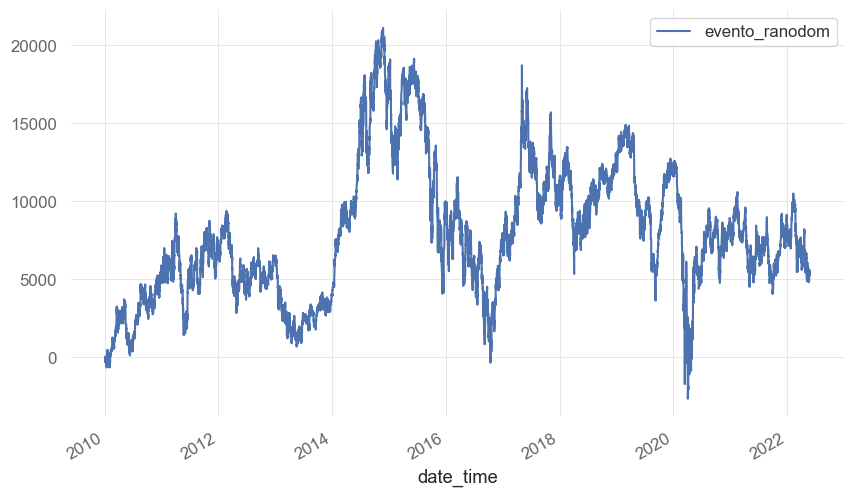

In [146]:
import gplearn
from gplearn.genetic import SymbolicClassifier
import random 
from IPython.display import clear_output


direzione = "long"

#direzione = "short"

OOS = len(X0)-int(len(X0)*0.2)

REAL_MONEY = len(X0)-int(len(X0)*0.1)

RANDOM_PARAMETERS = True

j0_ = dataset["PNL"].iloc[:REAL_MONEY].copy()
if direzione == "short":
    j0_ = -j0_
j0_ = j0_.fillna(0)
j0 =j0_

j0.cumsum().plot(label = "evento_ranodom")
plt.legend()
plt.show()

In [148]:
%%time


lsT = list(np.arange(0,len(X0.columns),1))
selected_features = random.sample(lsT, 56)
selected_features.sort()

costi = 0

def _mape(j,y,w):

    y=np.where(y>0.5,1,y)
    y=np.where(y!=1,0,y)
    y = np.roll(y, 1)
    y = propagate_ones(y, exit-1)

    if len(y)==len(j0):

        tmp_sum = (j0*y)
        
        tmp_sum = np.where((tmp_sum!=0)&(np.roll(tmp_sum,1)==0),tmp_sum-costi,tmp_sum)
        
        n_operations = len(tmp_sum[(tmp_sum!=0)&(np.roll(tmp_sum,1)==0)])
        
        a = TP_SL(tmp_sum ,TP,SL)

        tf_is = a[:OOS]
        tf_oos = a[OOS:]
  
        if (n_operations > 300) & (np.sum(tf_oos)/1>0): ###1000
            
            rank = np.sum(tf_is)/np.std(tf_is)   
            #rank = np.sum(tf_is)/abs(drawdown_max(tf_is))/np.std(tf_is) 
            #rank = np.mean(tf_is[tf_is!=0])*np.sqrt(np.sqrt(len(tf_is[tf_is!=0])))
            
            if (np.isinf(rank)) | (np.isnan(rank)): 
                return  -9999
            else:
                return rank
        else:
            return -99999
    else:
        return -99999


mape = gplearn.fitness.make_fitness(function=_mape ,greater_is_better=True)

if RANDOM_PARAMETERS :
    
    import random

    TP= 0#random.randrange(200, 1000, 100)
    SL= 0#random.randrange(500, 1000, 100)
    
    print("##### PARAMETRI RANDOMICI GENERAZIONE #####")
    print("")
    print("TakeProfit:",TP,"StopLoss:",SL)
    print("")

    while True :
        random_numbers = np.random.rand(4)
        total = np.sum(random_numbers)
        normalized_numbers = random_numbers / total
        rounded_numbers = np.round(normalized_numbers, 2)
        if np.sum(rounded_numbers) == 1:
            break
            
    random_population_size = 2**(np.random.randint(7, 10))  #### 12 == 2048
    print("population_size:",random_population_size)
    print("")
    print("p_crossover:",rounded_numbers[0] , "p_subtree_mutation:",rounded_numbers[1] , "p_hoist_mutation:",rounded_numbers[2] , "p_point_mutation:",rounded_numbers[3])
    print("")
    numero1 = np.random.randint(1, 4) #10
    numero2 = np.random.randint(numero1 + 1, 6) #11
    print("init_depth:",numero1,",",numero2)
    print("")
    
    est_gp = SymbolicClassifier(population_size = random_population_size , #500, 
                                parsimony_coefficient=0.01 , #'auto', ###default 0.001 anche 'auto' X overfit più alto meno overfit
                                generations=20, 
                                stopping_criteria=np.inf, 
                                verbose=1, 
                                random_state=None,
                                metric=mape , 
                                n_jobs=1,
                                function_set=function_set, 
                                low_memory=False,
                                p_crossover= rounded_numbers[0], #0.2, #
                                p_subtree_mutation= rounded_numbers[1], #0.3, 
                                p_hoist_mutation= rounded_numbers[2], #0.1, 
                                p_point_mutation= rounded_numbers[3], #0.2,
                                max_samples=1, 
                                tournament_size = 25, #####
                                init_depth= (numero1 , numero2), ##### influenza la lunghezza del programma 
                                init_method= 'full',#'half and half' , #'full', 
                                const_range=(0.,1.) ,warm_start=False)
    
    est_gp.fit(X0.iloc[:,selected_features].iloc[:REAL_MONEY] , y0.iloc[:REAL_MONEY]) #new_

else: 

    print("##### PARAMETRI STANDARD GENERAZIONE #####")

    TP= 0
    SL= 0
    
    est_gp = SymbolicClassifier(population_size = 500, 
                                parsimony_coefficient=0.001 , #'auto', ###default 0.001 anche 'auto' X overfit più alto meno overfit
                                generations=10, 
                                stopping_criteria=np.inf, 
                                verbose=1, 
                                random_state=None,
                                metric=mape , 
                                n_jobs=1,
                                function_set=function_set, 
                                low_memory=False,
                                p_crossover= 0.2, 
                                p_subtree_mutation= 0.3,  
                                p_hoist_mutation= 0.1, 
                                p_point_mutation= 0.2, 
                                max_samples=1, 
                                tournament_size = 25, 
                                init_depth= (2,10), ##### influenza la lunghezza del programma 
                                init_method= 'full', #'half and half' , #'full', 
                                const_range=(0.,1.) ,warm_start=False)
    
    est_gp.fit(X0.iloc[:,selected_features].iloc[:REAL_MONEY] , y0.iloc[:REAL_MONEY]) #new_

est_gp

##### PARAMETRI RANDOMICI GENERAZIONE #####

TakeProfit: 0 StopLoss: 0

population_size: 512

p_crossover: 0.13 p_subtree_mutation: 0.43 p_hoist_mutation: 0.16 p_point_mutation: 0.28

init_depth: 3 , 4

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.52         -84372.8        4          293.358              N/A     14.45s
   1     8.82           -45454       15          303.155              N/A     13.78s
   2     6.87         -38340.5       15          317.528              N/A     12.73s
   3     8.73         -29898.4       15          349.938              N/A     11.55s
   4    13.83         -20872.9       17           403.91              N/A     11.65s
   5    16.24           -19294       37          433.288              N/A     11.90s
   6    16.88         -21436.6       16   

SymbolicClassifier(const_range=(0.0, 1.0),
                   function_set=('neg', 'inv', 'add', 'mul', 'sqrt', 'log',
                                 'cos', 'sin', 'sub', 'div', 'min', 'max',
                                 'abs', 'tan'),
                   init_depth=(3, 4), init_method='full', max_samples=1,
                   metric=<gplearn.fitness._Fitness object at 0x000002005033CBE0>,
                   p_crossover=0.13, p_hoist_mutation=0.16,
                   p_point_mutation=0.28, p_subtree_mutation=0.43,
                   parsimony_coefficient=0.01, population_size=512,
                   stopping_criteria=inf, tournament_size=25, verbose=1)

Last Values Fittnes: 61620.0


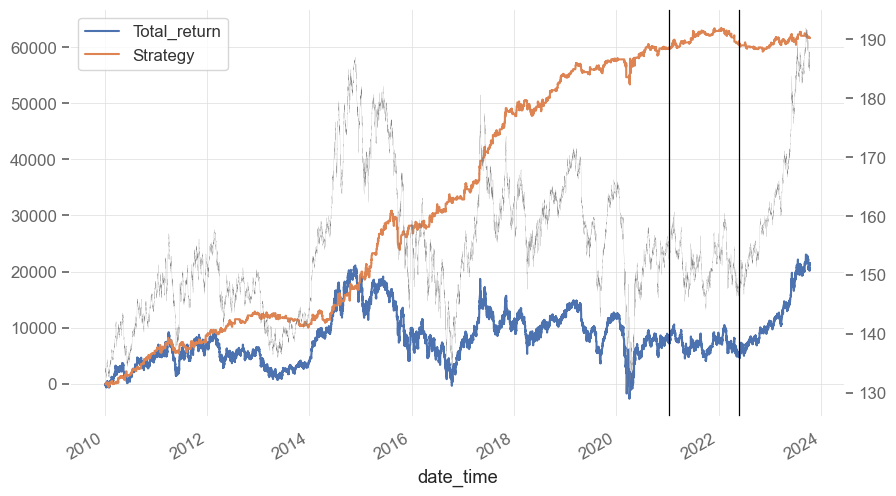

In [149]:
pred = est_gp._program.execute(X0.iloc[:,selected_features].values)
pred=np.where(pred>0,1,pred)
pred=np.where(pred!=1,0,pred)
pred = propagate_ones(pred, exit-1)

df = dataset.loc[:].PNL.to_frame("Total_return")

if direzione == "short":
    df=-df
df["pred"]=pred

df["Strategy"]=df.Total_return*df.pred.shift(1)
df["Strategy"] = df["Strategy"].fillna(0)
                                      
tmp_costi = TP_SL(df["Strategy"].to_numpy() ,TP,SL)

df["Strategy_NO_Costs"] = tmp_costi
df["Strategy_TP_SL"] =  np.where((tmp_costi!=0)&(np.roll(tmp_costi,1)==0),tmp_costi-costi,tmp_costi)

df[["Total_return","Strategy"]].cumsum().plot()

dataset.close.plot(secondary_y=True , linewidth=0.1 ,color="grey")
plt.axvline(x=y0.iloc[:OOS].index[-1], color="black" , linewidth=0.9)
plt.axvline(x=y0.iloc[:REAL_MONEY].index[-1], color="black" , linewidth=0.9)

print("Last Values Fittnes:",round(df["Strategy_TP_SL"].sum(),1))

In [87]:
####################### SAVE STRATEGY


hh = X0.iloc[:,selected_features].columns.to_list()
numbers = [int(element.split('ptn_')[1]) for element in hh]
ptn_=[]
for i in pattern_detect:
    if i[2][-1] in numbers:
        ptn_.append(i)

ptn_list = [ptn_ , THRESHOLD_VALUE , THRESHOLD_PATTERN]

info = [SIMBOLO,BIGPOINTVALUE,utc_offset,RESAMPLE,selected_hours, direzione]

import joblib
import os

os.chdir(r"C:\Users\Drako\GPlearn\DB")

data_to_save = {
    'numpy_array': ptn_list ,
    'test_file_path': info,
    'model': est_gp
}


import uuid

idz = uuid.uuid1()
save_as = SIMBOLO+"_GP_"+RESAMPLE+"_"+str(idz)+".joblib"

joblib.dump(data_to_save, save_as)


['LC_GP_60Min_922466e0-6cca-11ee-b0de-50e085baac0b.joblib']

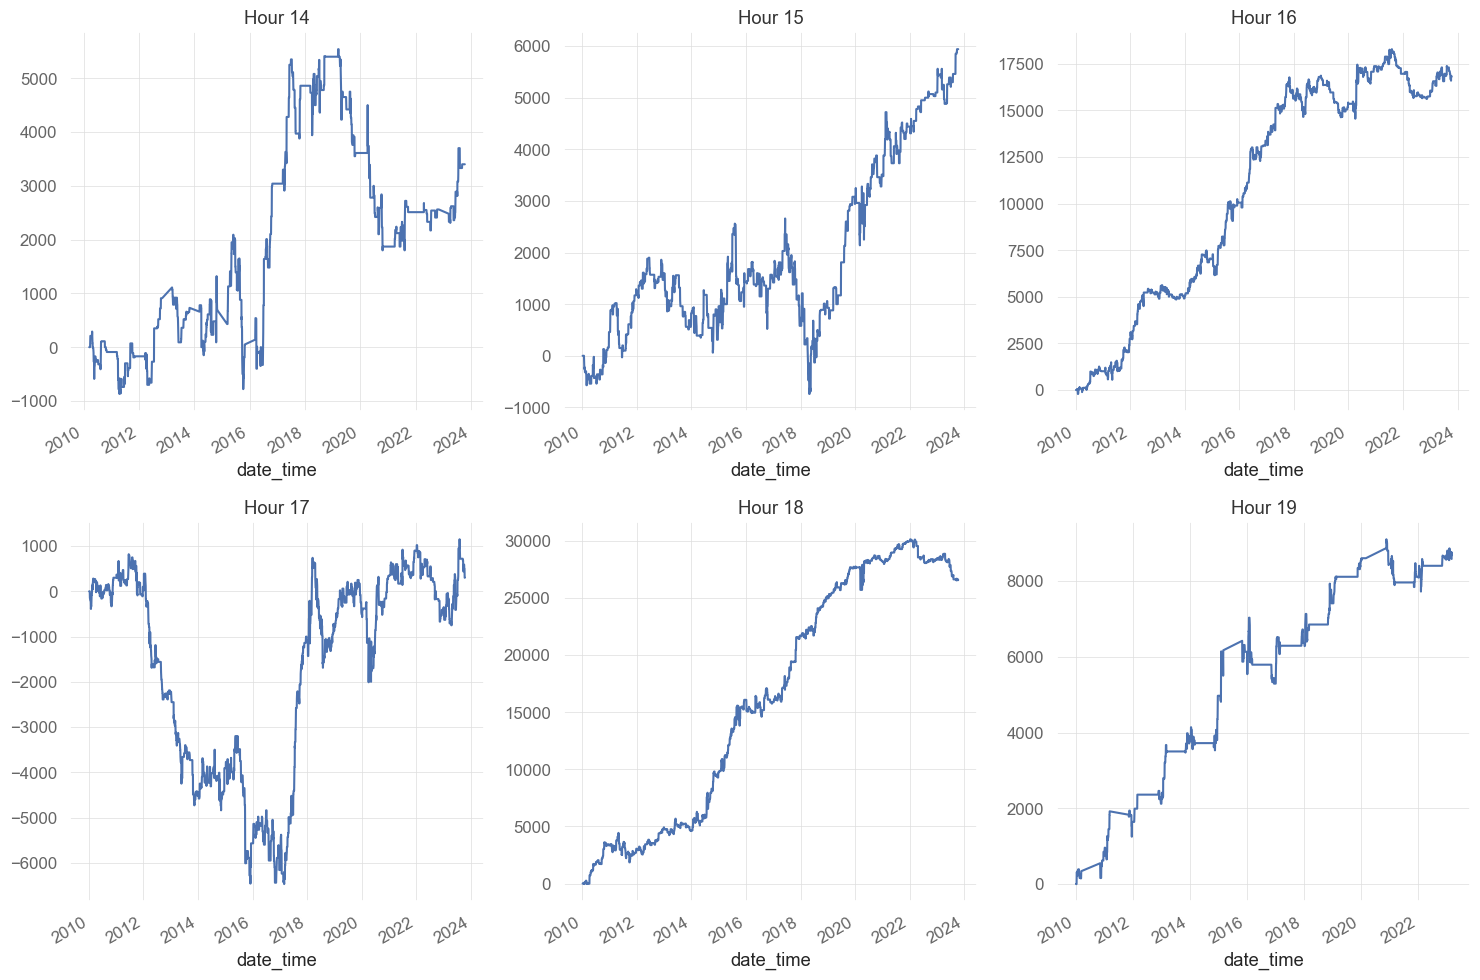

In [150]:
import numpy as np
import matplotlib.pyplot as plt

a = df["Strategy_TP_SL"]
ls_h = list(set(a.index.hour))
ls_h.sort()

# Specifica il numero di colonne per ogni riga
col_per_row = 3

# Calcola il numero totale di righe necessarie
num_rows = (len(ls_h) + col_per_row - 1) // col_per_row

# Crea una figura con sottofigure
fig, axes = plt.subplots(num_rows, col_per_row, figsize=(15, 5 * num_rows))

for i, e in enumerate(ls_h):
    row_idx = i // col_per_row
    col_idx = i % col_per_row

    # Seleziona l'asse appropriato
    if num_rows > 1:
        ax = axes[row_idx, col_idx]
    else:
        ax = axes[col_idx]

    # Traccia i dati e imposta il titolo
    a[a.index.hour == e].cumsum().plot(ax=ax, title="Hour " + str(e))

# Rimuovi eventuali sottofigure vuote
for i in range(len(ls_h), num_rows * col_per_row):
    if num_rows > 1:
        fig.delaxes(axes[i // col_per_row, i % col_per_row])
    else:
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [112]:
ls_h_ok = [15,16,18,19]

<Axes: xlabel='date_time'>

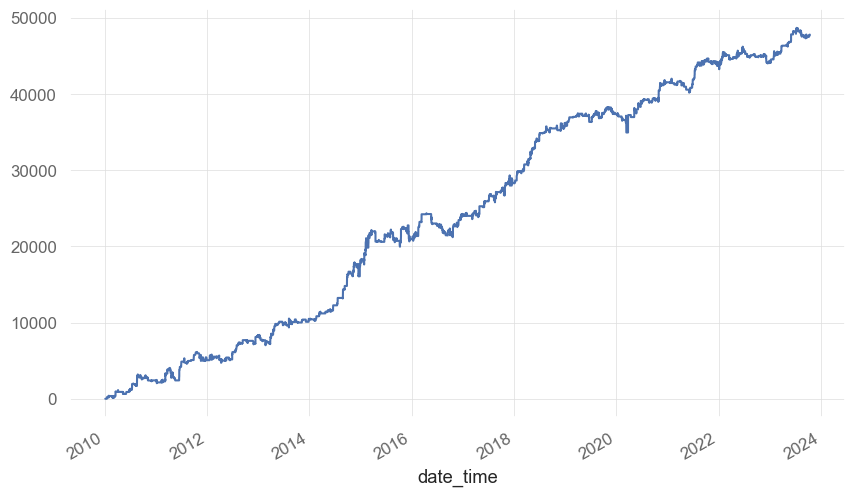

In [113]:
a[a.index.hour.isin(ls_h_ok)].cumsum().plot(label="Hour"+str(e))

In [151]:
newdf = df[["pred","Total_return"]].copy()
newdf = newdf.fillna(0)

idx = newdf.index
a=newdf.pred.shift(1 , fill_value=0)

if len(selected_hours)!=0:
    a[~a.index.hour.isin(selected_hours)]=0

b = newdf.Total_return.values
b=b*a

a[a==-1]=1
a=a.astype(int)
a=a.values
cnt = 0
for e in range(len(a)):
    try:
        if (a[e]==0)&(a[e+1]!=0):
            cnt=cnt+1
    except:
           cnt=cnt+1 
    if a[e]!=0:
        a[e]=cnt
        
trade_list=[]
for cnt_value in range(1, int(max(a)) + 1):
    mask =np.where(a==cnt_value)[0] 
    z = b[mask]
    tmp_index = np.where(a == cnt_value)[0]
    if len(tmp_index)>0:
        try:
            trade_list.append([round(np.sum(z),2),idx[tmp_index][0],idx[tmp_index+1][-1]])
        except:
            trade_list.append([round(np.sum(z),2),idx[tmp_index][0],idx[tmp_index][-1]])


tradelist = pd.DataFrame(trade_list)
tradelist.columns=(["operations","entry_time","exit_time"])
tradelist.set_index(["entry_time"],inplace=True)
tradelist.index = pd.to_datetime(tradelist.index)
tradelist["time_in_trade"] = tradelist.exit_time - tradelist.index
tradelist = tradelist[tradelist.operations!=0]
tradelist


,operations,exit_time,time_in_trade
entry_time,,,
2010-01-12 17:00:00,180.0,2010-01-13 15:00:00,0 days 22:00:00
2010-01-15 16:00:00,40.0,2010-01-15 19:00:00,0 days 03:00:00
2010-01-19 17:00:00,-90.0,2010-01-20 15:00:00,0 days 22:00:00
2010-01-22 18:00:00,-150.0,2010-01-25 16:00:00,2 days 22:00:00
2010-01-25 17:00:00,-140.0,2010-01-26 15:00:00,0 days 22:00:00
2010-01-26 16:00:00,-50.0,2010-01-26 19:00:00,0 days 03:00:00
2010-01-27 16:00:00,-180.0,2010-01-28 19:00:00,1 days 03:00:00
2010-02-01 17:00:00,260.0,2010-02-02 19:00:00,1 days 02:00:00
2010-02-03 15:00:00,60.0,2010-02-03 19:00:00,0 days 04:00:00


<Axes: xlabel='date_time'>

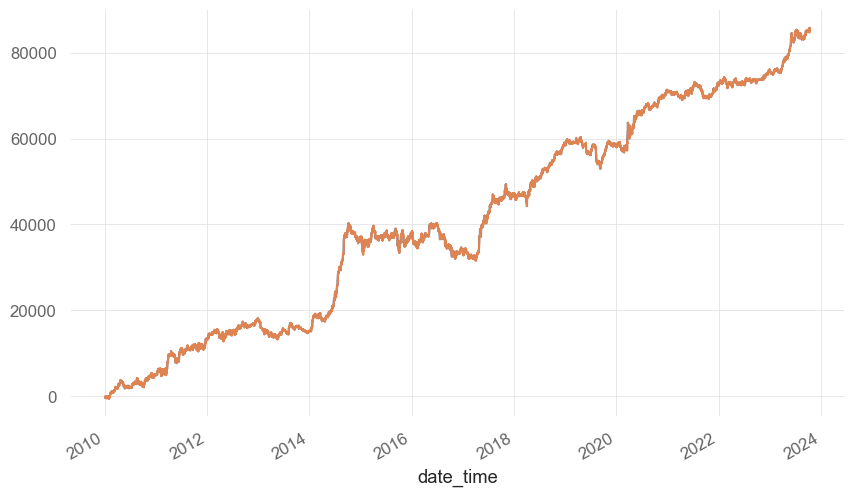

In [143]:
(tradelist.operations).cumsum().plot()
df["Strategy_TP_SL"].cumsum().plot()

In [116]:
k = (tradelist.operations).values

avg_t = []
avg_dd = []
for e in range(10000):
    np.random.shuffle(k)
    b=np.random.choice(k, size=int(len(k)*0.8))
    avg_t.append(np.sum(b))
    avg_dd.append(abs(drawdown_max(b)))
np.mean(avg_t)/np.mean(avg_dd)


8.136041203703236

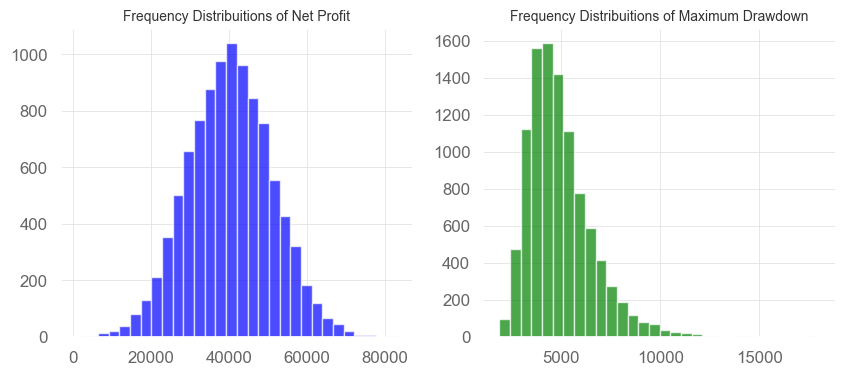

In [117]:
Avg_dd = pd.Series(avg_dd)
Avg_t = pd.Series(avg_t)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 riga, 2 colonne di subplot

# Disegna il primo istogramma nel primo subplot
axs[0].hist(Avg_t, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Frequency Distribuitions of Net Profit' , fontsize=10)

# Disegna il secondo istogramma nel secondo subplot
axs[1].hist(Avg_dd, bins=30, color='green', alpha=0.7)
axs[1].set_title('Frequency Distribuitions of Maximum Drawdown' , fontsize=10)

# Mostra i grafici
plt.show()

                    Strategy
------------------  ----------
Start Period        2010-01-15
End Period          2023-10-10
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   49.81%
CAGR﹪              2.05%

Sharpe              2.53
Prob. Sharpe Ratio  100.0%
Sortino             4.28
Sortino/√2          3.03
Omega               1.63

Max Drawdown        -3.75%
Longest DD Days     457

Gain/Pain Ratio     0.64
Gain/Pain (1M)      1.58

Payoff Ratio        1.38
Profit Factor       1.63
Common Sense Ratio  3.05
CPC Index           1.21
Tail Ratio          1.87
Outlier Win Ratio   4.24
Outlier Loss Ratio  3.89

MTD                 0.78%
3M                  0.85%
6M                  2.09%
YTD                 1.66%
1Y                  4.55%
3Y (ann.)           1.78%
5Y (ann.)           1.77%
10Y (ann.)          2.12%
All-time (ann.)     2.05%

Avg. Drawdown       -0.56%
Avg. Drawdown Days  47
Recovery Factor     10.91
Ulcer Index         0.01
Serenity Index      9.29


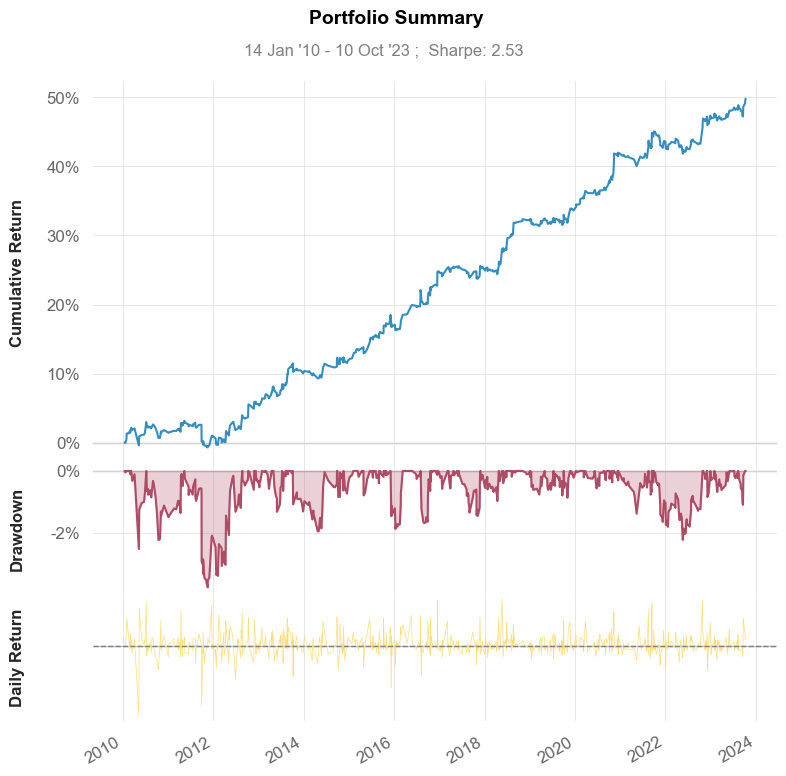

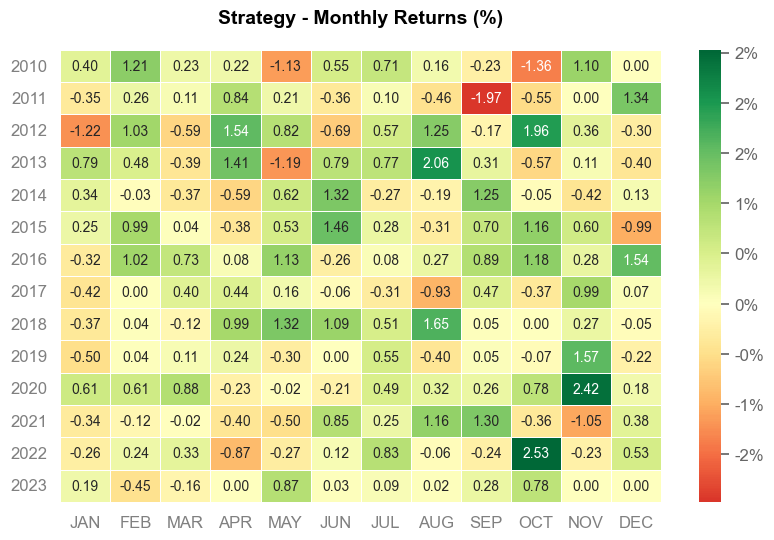

In [118]:
report(tradelist.operations,100000,1,"")